In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import keras
from keras.layers import Conv2D, MaxPool2D, CuDNNGRU, GlobalMaxPool2D, Reshape, \
concatenate, Input, TimeDistributed, Dense, BatchNormalization, SpatialDropout2D, SpatialDropout1D, Dropout, GlobalAvgPool2D, Flatten
from keras import Model
from keras.applications import Xception
import keras.backend as k
from sklearn.model_selection import train_test_split, KFold
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


mean intensity of optical flow: -0.03514303
mean intensity of frame: 61.88129


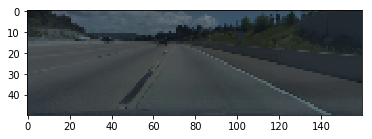

In [2]:

time_history = 1 # how many time steps to look back
hdf5_path = './train_data/train.hdf5'
with h5py.File(hdf5_path, "r") as f:
    print("mean intensity of optical flow:" , f["op_flow"][1].mean())
    print("mean intensity of frame:", f["frame"][5].mean())
    plt.imshow(f["frame"][5]/255)
    train_size = len(f["speed"])
    speed_data = list(f["speed"])
#     for i in range(train_size,train_size - 100):
        
#         frame, axarr = plt.subplots(1,2)
#         axarr[0].imshow(f["frame"][i])
#         axarr[1].imshow(f["op_flow"][i])
#         print(f['speed'][i])
#         plt.show()
#     plt.plot(speed_data)

mean intensity of optical flow: -0.005691097
20401


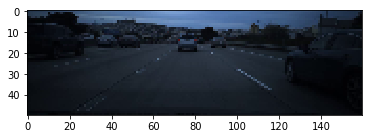

In [3]:
hdf5_path_comma = './train_data/comma_train.hdf5'
with h5py.File(hdf5_path_comma, "r") as f:
    print("mean intensity of optical flow:" ,f["op_flow"][50].mean())
    plt.imshow(f["frame"][6500]/255)
    print(len(f["speed"]))
    comma_train_size = len(f["speed"])
    comma_speed_data = list(f["speed"])

mean intensity of optical flow: -0.09879465
10798


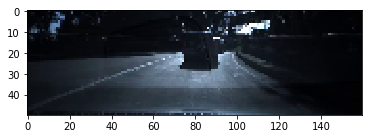

In [4]:
hdf5_path_comma_test = './test_data/comma_test.hdf5'
with h5py.File(hdf5_path_comma_test, "r") as f:
    print("mean intensity of optical flow:" ,f["op_flow"][2000].mean())
    plt.imshow(f["frame"][2000]/255)
    print(len(f["speed"]))
    comma_test_size = len(f["speed"])

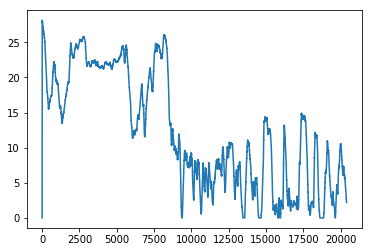

In [5]:
plt.plot(comma_speed_data)

In [6]:
print(train_size, comma_train_size)

151833 20401


In [7]:
import time
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, history_size, hdf5_path, indexes = None, validation_mode = False):
        self.hdf5_path = hdf5_path
        if indexes is None:
            with h5py.File(self.hdf5_path, "r") as f:
                self.indexes = np.arange(len(f["speed"]))
        else:
            self.indexes = indexes
        self.batch_size = batch_size
        self.history_size = history_size
        self.validation_mode = validation_mode
        if self.validation_mode == False:
            self.on_epoch_end()
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.indexes) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.validation_mode == False:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples'
        indexes = list(indexes)
        indexes.sort()
        frame = np.zeros((self.batch_size, 224, 224, 3))
        op_flow = np.zeros((self.batch_size, 50, 160, 2))
        speed = np.zeros((self.batch_size, 1))
        with h5py.File(self.hdf5_path, "r") as f:
            #self.frame = np.array(f["frame"][indexes])[batch_shuffles]
            op_flow = np.array(f["op_flow"][indexes])
            speed = np.array(f["speed"][indexes])
                
        return [
            #frame,
            op_flow], speed

In [8]:
index_array = np.arange(int(train_size))
#correcting for extra element at beginning of comma training data
comma_index_array = np.arange(int(comma_train_size) - 1)
comma_test_index_array = np.arange(int(comma_test_size) - 1)
# comma_train_indexes_no_shuf = np.copy(comma_train_indexes)
# comma_val_indexes_no_shuf = np.copy(comma_val_indexes)
# comma_train_indexes, comma_val_indexes = train_test_split(comma_index_array, shuffle = False, test_size = .2)

In [9]:
def build_model_flat(history_size):
    k.clear_session()
    #frame_inp = Input(shape=(224, 224, 3))
    op_flow_inp = Input(shape=(50, 160, 2))
    filters = [3, 5]
    op_flows = []
    #op_flow = BatchNormalization()(op_flow_inp)
    op_flow = (op_flow_inp)
    for i, filter_size in enumerate(filters):
        int_layer = Dropout(.0)(op_flow)
        int_layer = Conv2D(8, (filter_size,filter_size), activation = "relu", data_format = "channels_last")(int_layer)
        int_layer = MaxPool2D(pool_size = (1,2))(int_layer)
        int_layer = Conv2D(16, (filter_size,filter_size), activation = "relu", data_format = "channels_last")(int_layer)
        int_layer = MaxPool2D(pool_size = (1,2))(int_layer)
        int_layer = Conv2D(32, (filter_size,filter_size), activation = "relu", data_format = "channels_last")(int_layer)
        int_layer = Conv2D(64, (filter_size,filter_size), activation = "relu", data_format = "channels_last")(int_layer)
        int_layer = Dropout(.0)(int_layer)
        int_layer = Conv2D(128, (filter_size,filter_size), activation = "relu", data_format = "channels_last")(int_layer)
        int_layer = MaxPool2D()(int_layer)
        int_layer = Conv2D(256, (filter_size,filter_size), activation = "relu", data_format = "channels_last")(int_layer)
        int_layer = MaxPool2D()(int_layer)
        int_layer = Conv2D(512, (filter_size,filter_size), activation = "relu",
                           data_format = "channels_last", padding = "same")(int_layer)
        int_layer = MaxPool2D()(int_layer)
        int_layer_max = GlobalMaxPool2D()(int_layer)
        int_layer_avg = GlobalAvgPool2D()(int_layer)
        conc = concatenate([int_layer_max, int_layer_avg])
        op_flows.append(conc)
    conc = concatenate(op_flows)
    #conc = BatchNormalization()(conc)
    #conc = SpatialDropout1D(.2)(conc)
    #conc = CuDNNGRU(256)(conc)
    conc = Dropout(.2)(conc)
    conc = Dense(500, activation = "relu")(conc)
#     conc = Dropout(.2)(conc)
    conc = Dense(250, activation = "relu")(conc)
#     conc = Dropout(.1)(conc)
    result = Dense(1, activation='linear')(conc)
    
    model = Model(inputs=[
        #frame_inp,
        op_flow_inp], outputs=[result])
    model.compile(loss="mse", optimizer='adam')

    return model

In [10]:
def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

In [11]:
def evaluate_metrics(y_true, y_pred, title = None, verbose = False):
    #print(pd.DataFrame(y_pred).describe())
#     plt.figure(figsize=(12,4))
#     plt.subplot(1, 2, 1)
#     plt.plot(y_true)
#     plt.plot(y_pred)
#     plt.title("raw "+ title +  " predictions")
    for j in range(1,21,5):
        rolling_preds = runningMeanFast(y_pred, j)
        rolling_mse = mean_squared_error(y_true, rolling_preds)
    print("unsmoothed mse" , mean_squared_error(y_true, y_pred) , "\t" + str(j), "smoothed mse", str(rolling_mse))
#     plt.subplot(1, 2, 2)
#     plt.plot(y_true)
#     plt.plot(rolling_preds)
#     plt.title("smoothed "+ title +  " predictions")
#     plt.show()
    return rolling_mse, rolling_preds
    

training on fold 0
Epoch 1/1
3796/3796 [==============================] - 454s 120ms/step - loss: 23.2180
custom valid metrics
unsmoothed mse 17.845682 	16 smoothed mse 11.72658360490481
Epoch 1/1
510/510 [==============================] - 56s 110ms/step - loss: 5.9751
comma val metrics
unsmoothed mse 9.990998 	16 smoothed mse 7.211370667427236
Epoch 1/1
3796/3796 [==============================] - 456s 120ms/step - loss: 13.5521
custom valid metrics
unsmoothed mse 20.339148 	16 smoothed mse 13.216662858436182
Epoch 1/1
510/510 [==============================] - 56s 109ms/step - loss: 4.9847
comma val metrics
unsmoothed mse 9.51533 	16 smoothed mse 7.981123576114683
Epoch 1/1
3796/3796 [==============================] - 451s 119ms/step - loss: 11.3718
custom valid metrics
unsmoothed mse 12.908618 	16 smoothed mse 7.1700355614965625
Epoch 1/1
510/510 [==============================] - 56s 109ms/step - loss: 4.4443
comma val metrics
unsmoothed mse 8.672356 	16 smoothed mse 6.794468033007

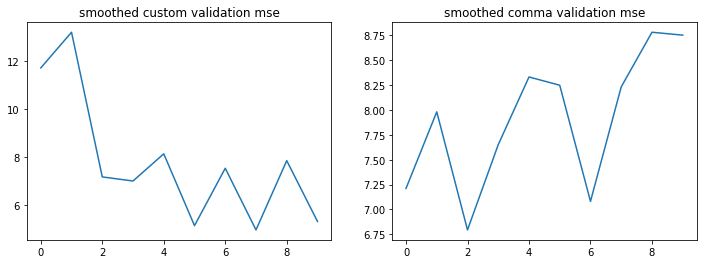

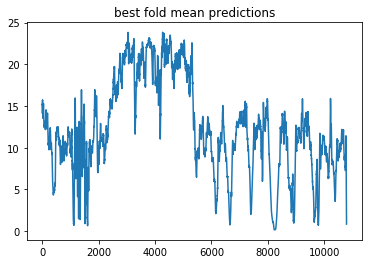

fold mean histograms


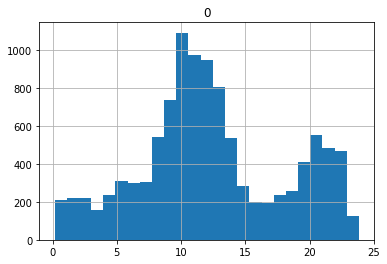

training on fold 1
Epoch 1/1
3796/3796 [==============================] - 460s 121ms/step - loss: 20.4481
custom valid metrics
unsmoothed mse 26.747513 	16 smoothed mse 18.128417452622127
Epoch 1/1
510/510 [==============================] - 56s 110ms/step - loss: 5.7771
comma val metrics
unsmoothed mse 15.151678 	16 smoothed mse 12.269524962613536
Epoch 1/1
3796/3796 [==============================] - 460s 121ms/step - loss: 12.1852
custom valid metrics
unsmoothed mse 18.923029 	16 smoothed mse 13.558099035766505
Epoch 1/1
510/510 [==============================] - 56s 110ms/step - loss: 4.5805
comma val metrics
unsmoothed mse 14.0099535 	16 smoothed mse 9.82368662883609
Epoch 1/1
3796/3796 [==============================] - 458s 121ms/step - loss: 10.3624
custom valid metrics
unsmoothed mse 20.315228 	16 smoothed mse 13.600535296426566
Epoch 1/1
510/510 [==============================] - 53s 103ms/step - loss: 4.3625
comma val metrics
unsmoothed mse 13.34155 	16 smoothed mse 8.0348851

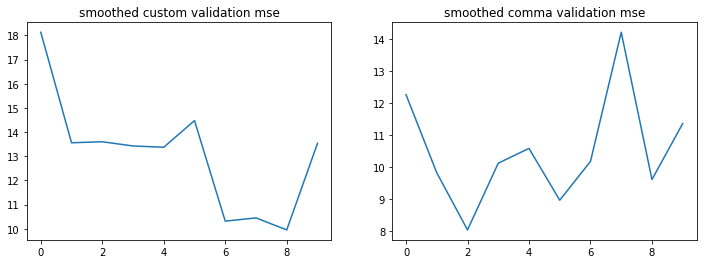

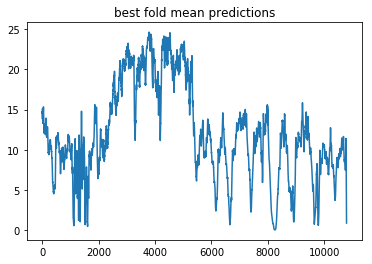

fold mean histograms


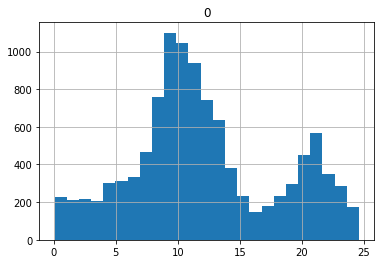

training on fold 2
Epoch 1/1
3796/3796 [==============================] - 461s 122ms/step - loss: 24.6493
custom valid metrics
unsmoothed mse 18.712229 	16 smoothed mse 13.39701966477753
Epoch 1/1
510/510 [==============================] - 56s 109ms/step - loss: 6.0087
comma val metrics
unsmoothed mse 11.225768 	16 smoothed mse 7.008941729657572
Epoch 1/1
3796/3796 [==============================] - 462s 122ms/step - loss: 12.6096
custom valid metrics
unsmoothed mse 15.592646 	16 smoothed mse 11.147829899549807
Epoch 1/1
510/510 [==============================] - 56s 110ms/step - loss: 5.0743
comma val metrics
unsmoothed mse 12.046751 	16 smoothed mse 8.031322478765537
Epoch 1/1
3796/3796 [==============================] - 462s 122ms/step - loss: 10.0840
custom valid metrics
unsmoothed mse 13.853809 	16 smoothed mse 9.477568707661908
Epoch 1/1
510/510 [==============================] - 56s 110ms/step - loss: 4.6772
comma val metrics
unsmoothed mse 10.368568 	16 smoothed mse 7.502275323

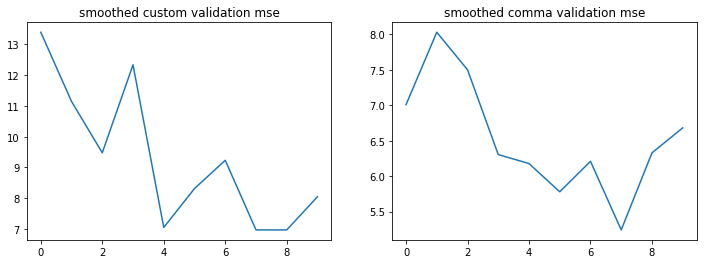

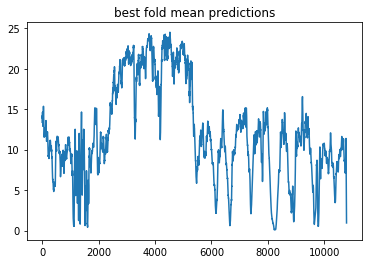

fold mean histograms


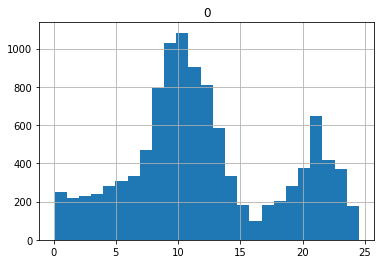

training on fold 3
Epoch 1/1
3796/3796 [==============================] - 471s 124ms/step - loss: 23.5302
custom valid metrics
unsmoothed mse 12.619921 	16 smoothed mse 7.848295057292025
Epoch 1/1
510/510 [==============================] - 56s 110ms/step - loss: 6.4401
comma val metrics
unsmoothed mse 9.163071 	16 smoothed mse 5.794520096023704
Epoch 1/1
3796/3796 [==============================] - 467s 123ms/step - loss: 13.5492
custom valid metrics
unsmoothed mse 11.737404 	16 smoothed mse 7.183249542469412
Epoch 1/1
510/510 [==============================] - 56s 111ms/step - loss: 5.5420
comma val metrics
unsmoothed mse 9.325732 	16 smoothed mse 5.747725209387715
Epoch 1/1
3796/3796 [==============================] - 467s 123ms/step - loss: 11.0906
custom valid metrics
unsmoothed mse 10.83359 	16 smoothed mse 6.631488275880662
Epoch 1/1
510/510 [==============================] - 56s 110ms/step - loss: 5.2345
comma val metrics
unsmoothed mse 9.661849 	16 smoothed mse 6.10654623346779

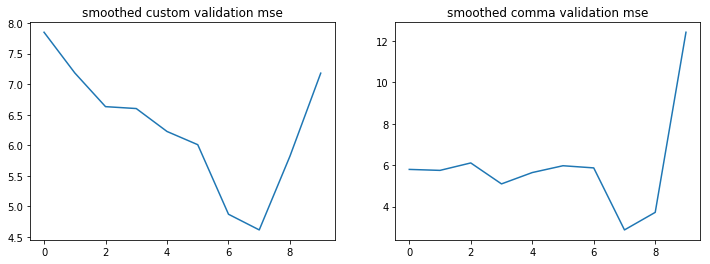

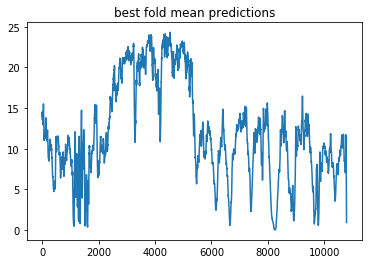

fold mean histograms


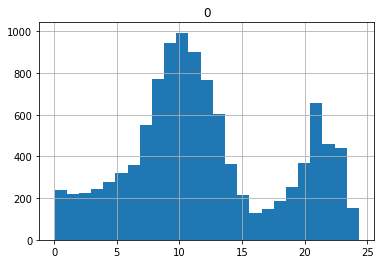

training on fold 4
Epoch 1/1
3796/3796 [==============================] - 450s 119ms/step - loss: 24.2652
custom valid metrics
unsmoothed mse 16.001095 	16 smoothed mse 8.967145074733123
Epoch 1/1
510/510 [==============================] - 55s 108ms/step - loss: 7.2036
comma val metrics
unsmoothed mse 7.7305665 	16 smoothed mse 6.0399594214321946
Epoch 1/1
3796/3796 [==============================] - 449s 118ms/step - loss: 13.8578
custom valid metrics
unsmoothed mse 14.448364 	16 smoothed mse 8.109861977846327
Epoch 1/1
510/510 [==============================] - 56s 109ms/step - loss: 5.8712
comma val metrics
unsmoothed mse 6.285473 	16 smoothed mse 4.691406879005087
Epoch 1/1
3796/3796 [==============================] - 452s 119ms/step - loss: 11.0028
custom valid metrics
unsmoothed mse 17.50178 	16 smoothed mse 10.39887955256498
Epoch 1/1
510/510 [==============================] - 56s 110ms/step - loss: 5.8712
comma val metrics
unsmoothed mse 4.7242393 	16 smoothed mse 2.99170569629

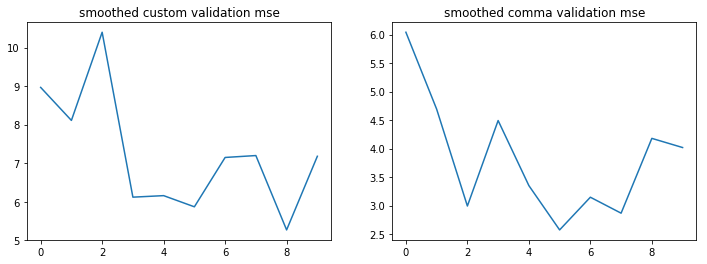

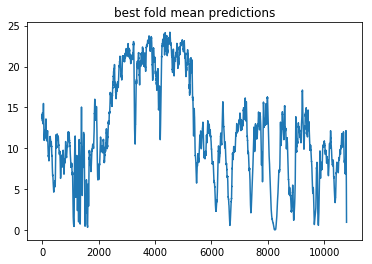

fold mean histograms


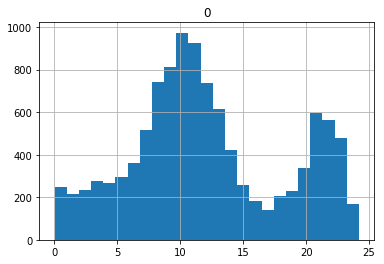

In [17]:
split_count = 5
num_epochs = 10
steps_per_epoch = None
kf = KFold(shuffle = False, n_splits = split_count)
test_preds = np.zeros((split_count, len(comma_test_index_array)))
oof_preds = np.zeros((len(index_array)))
comma_oof_preds = np.zeros((len(comma_index_array)))
custom_splits = list(kf.split(index_array))
comma_splits = list(kf.split(comma_index_array))
for fold in range(split_count):
    train_indexes, val_indexes = custom_splits[fold]
    comma_train_indexes, comma_val_indexes = comma_splits[fold]
    print("training on fold " + str(fold))
    print("="*80)
    
    best_comma_mse = 200
    best_custom_mse = 200
    
    comma_train_generator = DataGenerator(32, time_history, hdf5_path_comma, indexes = comma_train_indexes)
    comma_val_generator =  DataGenerator(32, time_history, hdf5_path_comma, indexes = comma_val_indexes, validation_mode = True)
    comma_test_generator = DataGenerator(32, time_history, hdf5_path_comma_test, indexes = comma_test_index_array, validation_mode = True)
    
    train_generator = DataGenerator(32, time_history, hdf5_path, indexes = train_indexes)
    valid_generator = DataGenerator(32, time_history, hdf5_path, indexes = val_indexes, validation_mode = True)
    
    model_flat = build_model_flat(time_history)
    comma_mse = []
    custom_mse = []
    
    for i in range(num_epochs):
        model_flat.fit_generator(train_generator, epochs = 1, steps_per_epoch=steps_per_epoch)
        val_predictions = model_flat.predict_generator(valid_generator)[:, 0]
        print("custom valid metrics")
        val_roll_mse, val_roll_preds = evaluate_metrics(np.array(speed_data)[val_indexes], val_predictions, title = "custom data")
        custom_mse.append(val_roll_mse)
        if val_roll_mse < best_custom_mse:
            oof_preds[val_indexes] = val_roll_preds
    
        model_flat.fit_generator(comma_train_generator, epochs = 1, steps_per_epoch=steps_per_epoch)
        print("comma val metrics")
        comma_val_predictions = model_flat.predict_generator(comma_val_generator)[:, 0]
        comma_roll_mse, comma_roll_preds = evaluate_metrics(np.array(comma_speed_data)[comma_val_indexes], comma_val_predictions, title = "comma data")
        comma_mse.append(comma_roll_mse)
        if comma_roll_mse < best_comma_mse:
            model_flat.save("best_model" + str(fold) + ".ckpt")
            comma_test_predictions = model_flat.predict_generator(comma_test_generator)[:, 0][comma_test_index_array]
            comma_test_predictions = runningMeanFast(comma_test_predictions, 21)
            test_preds[fold, :] = comma_test_predictions
            comma_oof_preds[comma_val_indexes] = comma_roll_preds
            best_comma_mse = comma_roll_mse
        
#         plt.plot(comma_test_predictions)
#         plt.plot(np.mean(test_preds[:fold+1], axis = 0))
#         plt.title("comma test predictions")
#         plt.show()
        
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.plot(custom_mse)
    plt.title("smoothed custom validation mse")
    plt.subplot(1, 2, 2)
    plt.plot(comma_mse)
    plt.title("smoothed comma validation mse")
    plt.show()

    fold_means = np.mean(test_preds[:fold+1], axis = 0)
    plt.plot(fold_means)
    plt.title("best fold mean predictions")
    plt.show()
    print("fold mean histograms")
    pd.DataFrame(fold_means).hist(bins = 25)
    plt.show()

In [25]:
#comma oof performance
print(mean_squared_error(comma_speed_data[1:], comma_oof_preds))

#custom off performance
print(mean_squared_error(speed_data, oof_preds))

5.067375083527054
8.25015783430225


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025D87F75438>]],
      dtype=object)

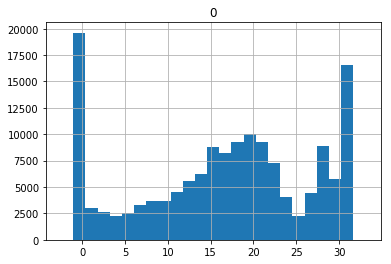

In [27]:
pd.DataFrame(speed_data).hist(bins = 25)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025DE77844A8>]],
      dtype=object)

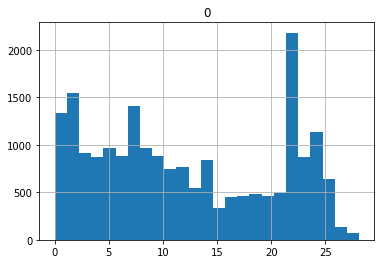

In [28]:
pd.DataFrame(comma_speed_data).hist(bins = 25)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025DF4F6C0B8>]],
      dtype=object)

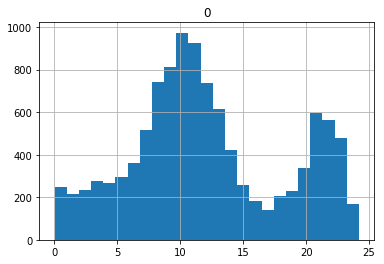

In [31]:
pd.DataFrame(fold_means).hist(bins = 25)

In [40]:
with open("test.txt", "w") as f:
    for line in [13] + list(fold_means):
        f.write(str(line) + "\n")
fold_means

array([13.41369704, 14.08682982, 14.11967446, ...,  2.60811919,
        1.80955536,  0.97247431])

In [20]:
def build_model(history_size):
    k.clear_session()
    frame_inp = Input(shape=(history_size, 224, 224, 3))
    op_flow_inp = Input(shape=(history_size, 224, 224, 3))
    filter_size = (3,3)
    #frame = TimeDistributed(BatchNormalization())(frame_inp)
    frame = TimeDistributed(SpatialDropout2D(.2))(frame_inp)
    frame = TimeDistributed(Conv2D(4, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame = TimeDistributed(Conv2D(4, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame = TimeDistributed(Conv2D(8, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame = TimeDistributed(Conv2D(16, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    #frame = TimeDistributed(SpatialDropout2D(.2))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame = TimeDistributed(Conv2D(32, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame = TimeDistributed(GlobalMaxPool2D())(frame)
    
    op_flow = TimeDistributed(BatchNormalization())(op_flow_inp)
    op_flow = TimeDistributed(Dropout(.3))(op_flow)
    op_flow = TimeDistributed(Conv2D(4, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(8, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(32, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(64, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(Dropout(.3))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(128, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow_max = TimeDistributed(GlobalMaxPool2D())(op_flow)
    op_flow_avg = TimeDistributed(GlobalAvgPool2D())(op_flow)
    
    conc = concatenate([op_flow_max, op_flow_avg,
                       #frame
                       ])
    #conc = BatchNormalization()(conc)
    conc = SpatialDropout1D(.2)(conc)
    conc = CuDNNGRU(256)(conc)
    conc = Dense(100, activation = "relu")(conc)
    conc = Dropout(.2)(conc)
    conc = Dense(50, activation = "relu")(conc)
    conc = Dropout(.1)(conc)
    result = Dense(1, activation='linear')(conc)
    
    model = Model(inputs=[frame_inp, op_flow_inp], outputs=[result])
    print(model.summary())
    model.compile(loss="mse", optimizer='adam')

    return model

In [86]:
model = build_model(time_history)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1, 224, 224,  0                                            
__________________________________________________________________________________________________
time_distributed_13 (TimeDistri (None, 1, 224, 224,  12          input_2[0][0]                    
__________________________________________________________________________________________________
time_distributed_14 (TimeDistri (None, 1, 224, 224,  0           time_distributed_13[0][0]        
__________________________________________________________________________________________________
time_distributed_15 (TimeDistri (None, 1, 222, 222,  112         time_distributed_14[0][0]        
__________________________________________________________________________________________________
time_distr

In [87]:
hist = model.fit_generator(train_generator, validation_data=valid_generator, epochs = 10, 
                           callbacks=[EarlyStopping(patience=3), ModelCheckpoint(filepath="rnn_model.ckpt", save_weights_only=False)])

Epoch 1/10
1061/1061 [==============================] - 619s 584ms/step - loss: 40.8469 - val_loss: 141.1516
Epoch 2/10
1061/1061 [==============================] - 614s 579ms/step - loss: 17.7586 - val_loss: 91.3322
Epoch 3/10
1061/1061 [==============================] - 620s 584ms/step - loss: 14.0745 - val_loss: 91.2476
Epoch 4/10
1061/1061 [==============================] - 636s 600ms/step - loss: 12.2106 - val_loss: 77.1058
Epoch 5/10
1061/1061 [==============================] - 621s 586ms/step - loss: 10.8576 - val_loss: 98.6059
Epoch 6/10
 334/1061 [========>.....................] - ETA: 5:58 - loss: 10.2859

KeyboardInterrupt: 

In [26]:
hist2 = model_flat.fit_generator(train_generator, validation_data=valid_generator, epochs = 10)

Epoch 1/10
850/850 [==============================] - 64s 75ms/step - loss: 10.2186 - val_loss: 7.8661
Epoch 2/10
850/850 [==============================] - 54s 63ms/step - loss: 6.9825 - val_loss: 10.1133
Epoch 3/10
850/850 [==============================] - 52s 61ms/step - loss: 6.1236 - val_loss: 14.2986
Epoch 4/10
850/850 [==============================] - 52s 61ms/step - loss: 5.2178 - val_loss: 12.8146
Epoch 5/10
850/850 [==============================] - 52s 61ms/step - loss: 4.7625 - val_loss: 9.2727
Epoch 6/10
329/850 [==========>...................] - ETA: 26s - loss: 4.4986

KeyboardInterrupt: 

In [30]:
hist2 = model_flat.fit_generator(train_generator, validation_data=valid_generator, epochs = 10)

Epoch 1/10
1020/1020 [==============================] - 61s 59ms/step - loss: 9.1252 - val_loss: 6.3036
Epoch 2/10
1020/1020 [==============================] - 60s 59ms/step - loss: 5.7693 - val_loss: 5.7843
Epoch 3/10
1020/1020 [==============================] - 60s 59ms/step - loss: 5.0111 - val_loss: 8.4845
Epoch 4/10
1020/1020 [==============================] - 60s 59ms/step - loss: 4.5018 - val_loss: 9.0041
Epoch 5/10
1020/1020 [==============================] - 60s 58ms/step - loss: 4.5581 - val_loss: 6.3973
Epoch 6/10
1020/1020 [==============================] - 60s 58ms/step - loss: 4.3193 - val_loss: 7.4391
Epoch 7/10
1020/1020 [==============================] - 59s 58ms/step - loss: 4.0120 - val_loss: 17.6570
Epoch 8/10
1020/1020 [==============================] - 60s 59ms/step - loss: 3.4943 - val_loss: 9.9679
Epoch 9/10
1020/1020 [==============================] - 60s 58ms/step - loss: 3.6226 - val_loss: 10.5491
Epoch 10/10
1020/1020 [==============================] - 60s 5

In [53]:
def build_model_frame(history_size):
    k.clear_session()
    frame_inp = Input(shape=(history_size, 224, 224, 3))
    op_flow_inp = Input(shape=(history_size, 224, 224, 3))
    filter_size = (3,3)
    base_mod = Xception(weights='imagenet', include_top=False, input_shape = (224,224,3))
    for l in base_mod.layers: 
        l.trainable=False
    frame = TimeDistributed(BatchNormalization())(frame_inp)
    frame = TimeDistributed(base_mod)(frame)
    #frame = Reshape(target_shape=(history_size, 2048))(frame)
    frame = TimeDistributed(Conv2D(128, (1,1), activation = "relu"))(frame)
    frame_max = TimeDistributed(GlobalMaxPool2D())(frame)
    frame_avg = TimeDistributed(GlobalAvgPool2D())(frame)
    
    op_flow = TimeDistributed(BatchNormalization())(op_flow_inp)
    op_flow = TimeDistributed(Dropout(.3))(op_flow)
    op_flow = TimeDistributed(Conv2D(4, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(8, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(32, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(64, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(Dropout(.3))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(128, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow_max = TimeDistributed(GlobalMaxPool2D())(op_flow)
    op_flow_avg = TimeDistributed(GlobalAvgPool2D())(op_flow)
    
    conc = concatenate([
        #frame_max, frame_avg,
        op_flow_max, op_flow_avg
    ])
    conc = BatchNormalization()(conc)
    #conc = SpatialDropout1D(.2)(conc)
    #conc = CuDNNGRU(256)(conc)
    conc = Flatten()(conc)
    conc = Dropout(.3)(conc)
    conc = Dense(500, activation = "relu")(conc)
    conc = Dropout(.2)(conc)
    conc = Dense(100, activation = "relu")(conc)
    conc = Dropout(.1)(conc)
    result = Dense(1, activation='linear')(conc)
    
    model = Model(inputs=[frame_inp, op_flow_inp], outputs=[result])
    print(model.summary())
    model.compile(loss="mse", optimizer='adam')

    return model

In [54]:
model3 = build_model_frame(time_history)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 3, 224, 224,  0                                            
__________________________________________________________________________________________________
time_distributed_6 (TimeDistrib (None, 3, 224, 224,  12          input_2[0][0]                    
__________________________________________________________________________________________________
time_distributed_7 (TimeDistrib (None, 3, 224, 224,  0           time_distributed_6[0][0]         
__________________________________________________________________________________________________
time_distributed_8 (TimeDistrib (None, 3, 222, 222,  112         time_distributed_7[0][0]         
__________________________________________________________________________________________________
time_distr

In [55]:
hist3 = model3.fit_generator(train_generator, validation_data=valid_generator, epochs = 10)

Epoch 1/10
1020/1020 [==============================] - 163s 159ms/step - loss: 28.2054 - val_loss: 12.9030
Epoch 2/10
1020/1020 [==============================] - 160s 157ms/step - loss: 13.6002 - val_loss: 18.9242
Epoch 3/10
1020/1020 [==============================] - 158s 155ms/step - loss: 10.7904 - val_loss: 11.0065
Epoch 4/10
1020/1020 [==============================] - 159s 156ms/step - loss: 8.6554 - val_loss: 13.5720
Epoch 5/10
1020/1020 [==============================] - 160s 156ms/step - loss: 7.8862 - val_loss: 5.3888
Epoch 6/10
1020/1020 [==============================] - 161s 157ms/step - loss: 6.3103 - val_loss: 7.8890
Epoch 7/10
1020/1020 [==============================] - 160s 157ms/step - loss: 5.9375 - val_loss: 7.0740
Epoch 8/10
1020/1020 [==============================] - 160s 156ms/step - loss: 5.4968 - val_loss: 9.8594
Epoch 9/10
1020/1020 [==============================] - 160s 157ms/step - loss: 4.8999 - val_loss: 8.6684
Epoch 10/10
1020/1020 [================

In [59]:
def build_model_frame(history_size):
    k.clear_session()
    frame_inp = Input(shape=(history_size, 224, 224, 3))
    op_flow_inp = Input(shape=(history_size, 224, 224, 3))
    filter_size = (3,3)
    base_mod = Xception(weights='imagenet', include_top=False, input_shape = (224,224,3))
    for l in base_mod.layers: 
        l.trainable=False
    #frame = TimeDistributed(BatchNormalization())(frame_inp)
    frame = TimeDistributed(base_mod)(frame_inp)
    #frame = Reshape(target_shape=(history_size, 2048))(frame)
    frame = TimeDistributed(Conv2D(128, (1,1), activation = "relu"))(frame)
    frame_max = TimeDistributed(GlobalMaxPool2D())(frame)
    frame_avg = TimeDistributed(GlobalAvgPool2D())(frame)
    
    op_flow = TimeDistributed(BatchNormalization())(op_flow_inp)
    op_flow = TimeDistributed(Dropout(.3))(op_flow)
    op_flow = TimeDistributed(Conv2D(4, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(8, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(32, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(64, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(Dropout(.3))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(128, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow_max = TimeDistributed(GlobalMaxPool2D())(op_flow)
    op_flow_avg = TimeDistributed(GlobalAvgPool2D())(op_flow)
    
    conc = concatenate([
        frame_max, frame_avg,
        #op_flow_max, op_flow_avg
    ])
    conc = BatchNormalization()(conc)
    #conc = SpatialDropout1D(.2)(conc)
    #conc = CuDNNGRU(256)(conc)
    conc = Flatten()(conc)
    conc = Dropout(.3)(conc)
    conc = Dense(500, activation = "relu")(conc)
    conc = Dropout(.2)(conc)
    conc = Dense(100, activation = "relu")(conc)
    conc = Dropout(.1)(conc)
    result = Dense(1, activation='linear')(conc)
    
    model = Model(inputs=[frame_inp, op_flow_inp], outputs=[result])
    print(model.summary())
    model.compile(loss="mse", optimizer='adam')

    return model

In [60]:
model4 = build_model_frame(time_history)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 224, 224,  0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 3, 7, 7, 2048 20861480    input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 3, 7, 7, 128) 262272      time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 3, 128)       0           time_distributed_2[0][0]         
__________________________________________________________________________________________________
time_distr

In [61]:
hist4 = model4.fit_generator(train_generator, validation_data=valid_generator, epochs = 10)

Epoch 1/10
1020/1020 [==============================] - 278s 273ms/step - loss: 13.5584 - val_loss: 86.6192
Epoch 2/10
 146/1020 [===>..........................] - ETA: 3:08 - loss: 7.3752

KeyboardInterrupt: 